In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
from tensorflow.keras import backend as K
import argparse
import os
import sys
from random import getrandbits
from keras.callbacks import History 
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD

Using TensorFlow backend.


In [15]:
def EdgespeechnetC():
    model = tf.keras.models.Sequential([
        tf.keras.layers.SeparableConv2D(24, (3,3), activation='relu', input_shape=(160,101,1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.AvgPool2D((3,3)),
        
        tf.keras.layers.SeparableConv2D(6, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.SeparableConv2D(24, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.SeparableConv2D(9, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.SeparableConv2D(24, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.SeparableConv2D(12, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.SeparableConv2D(24, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.SeparableConv2D(6, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.SeparableConv2D(24, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.SeparableConv2D(5, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.SeparableConv2D(24, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.SeparableConv2D(6, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.SeparableConv2D(24, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.SeparableConv2D(2, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.SeparableConv2D(24, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.SeparableConv2D(45, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.AvgPool2D((3,3)),

        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(30),
        tf.keras.layers.Softmax()

    ])
    
    return model

In [16]:
def EdgespeechnetD():
    model = tf.keras.models.Sequential([
        tf.keras.layers.SeparableConv2D(45, (3,3), activation='relu', input_shape=(160,101,1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.AvgPool2D((3,3)),
        
        tf.keras.layers.SeparableConv2D(30, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.SeparableConv2D(45, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.SeparableConv2D(33, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.SeparableConv2D(45, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.SeparableConv2D(35, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.SeparableConv2D(45, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.AvgPool2D((3,3)),

        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(30),
        tf.keras.layers.Softmax()

    ])
    
    return model

In [17]:
model = EdgespeechnetC()

In [18]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_47 (Separab (None, 158, 99, 24)       57        
_________________________________________________________________
batch_normalization_48 (Batc (None, 158, 99, 24)       96        
_________________________________________________________________
average_pooling2d_3 (Average (None, 52, 33, 24)        0         
_________________________________________________________________
separable_conv2d_48 (Separab (None, 50, 31, 6)         366       
_________________________________________________________________
batch_normalization_49 (Batc (None, 50, 31, 6)         24        
_________________________________________________________________
separable_conv2d_49 (Separab (None, 48, 29, 24)        222       
_________________________________________________________________
batch_normalization_50 (Batc (None, 48, 29, 24)       

In [19]:
def random_onoff():                # randomly turns on or off
    return bool(getrandbits(1))


def augment_signal(y, sr, quiet=True):
    count_changes = 0
    allow_pitch, allow_dyn, allow_noise = True, True, True
    y_mod = y
    # change pitch (w/o speed)
    if (allow_pitch) and random_onoff():
        bins_per_octave = 24  # pitch increments are quarter-steps
        pitch_pm = 4  # +/- this many quarter steps
        pitch_change = pitch_pm * 2 * (np.random.uniform() - 0.5)
        if not quiet:
            print("    pitch_change = ", pitch_change)
        y_mod = librosa.effects.pitch_shift(y, sr, n_steps=pitch_change, bins_per_octave=bins_per_octave)
        count_changes += 1
    # change dynamic range
    if (allow_dyn) and random_onoff():
        dyn_change = np.random.uniform(low=0.5, high=1.1)  # change amplitude
        if not quiet:
            print("    dyn_change = ", dyn_change)
        y_mod = y_mod * dyn_change
        count_changes += 1
        # add noise
    if (allow_noise) and random_onoff():
        noise_amp = 0.005 * np.random.uniform() * np.amax(y)
        if random_onoff():
            if not quiet:
                print("    gaussian noise_amp = ", noise_amp)
            y_mod += noise_amp * np.random.normal(size=len(y))
        else:
            if not quiet:
                print("    uniform noise_amp = ", noise_amp)
            y_mod += noise_amp * np.random.uniform(size=len(y))
        count_changes += 1

    # last-ditch effort to make sure we made a change (recursive/sloppy, but...works)
    if (0 == count_changes):
        if not quiet:
            print("No changes made to signal, trying again")
        y_mod = augment_signal(y_mod, sr, quiet=quiet)

    return y_mod


def spect_loader(path, window_size=.02, window_stride=.01, window='hamming', normalize=True, max_len=101, augment=False):
    y, sr = sf.read(path)
    y_original_len = len(y)
    
    if augment:
        y = augment_signal(y, sr)
    if not len(y) == y_original_len:
        print('augmentation ruined the audio files length!!!')
        exit()
    
    try:
        n_fft = int(sr * window_size)
    except:
        print(path)

    win_length = n_fft
    hop_length = int(sr * window_stride)
    
    # STFT
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window)
    
    spect, phase = librosa.magphase(D)
    spect = np.log1p(spect)
    real_features_len = spect.shape[1]
    
    # make all spects with the same dims
    if spect.shape[1] < max_len:
        pad = np.zeros((spect.shape[0], max_len - spect.shape[1]))
        spect = np.hstack((spect, pad))
    elif spect.shape[1] > max_len:
        spect = spect[:, :max_len]

    if spect.shape[0] < 160:
        pad = np.zeros((160 - spect.shape[0], spect.shape[1]))
        spect = np.vstack((spect, pad))
    elif spect.shape[0] > 160:
        spect = spect[:160, :]
    spect = np.resize(spect, (spect.shape[0], spect.shape[1], 1))
    #spect = torch.FloatTensor(spect) 
    
    #normalization to zero-mean and one-std
    normalize = True
    if normalize:
        mean = np.mean(spect)
        std = np.std(spect)
        if std != 0:
            spect = spect - mean
            spect = spect / std
            
    return spect, len(y), real_features_len, sr

In [20]:
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if (os.path.isdir(os.path.join(dir, d)))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

AUDIO_EXTENSIONS = ['.wav', '.WAV']

def is_audio_file(filename):
    return any(filename.endswith(extension) for extension in AUDIO_EXTENSIONS)

def DataLoader(path, window_size, window_stride, window_type, normalize, max_len):
    classes, class_to_idx = find_classes(path)

    spects = []
    root_dir = os.path.expanduser(path)
    count = 0

    for data in sorted(os.listdir(root_dir)):
        d = os.path.join(root_dir, data)
        if not os.path.isdir(d):
            continue
        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if is_audio_file(fname):
                    path = os.path.join(root, fname)
                    label = os.path.join(root, fname.replace(".wav", ".wrd"))
                    item = (path, class_to_idx[data], label)
                    spects.append(item)
                    count += 1

    if len(spects) == 0:
        raise (RuntimeError("Found 0 sound files in subfolders of: " + path + "Supported audio file extensions are: " + ",".join(AUDIO_EXTENSIONS)))

    dataset = []

    for index in range(np.shape(spects)[0]):
        data_dir, target, label_path = spects[index]
        spect, _, _, _ = spect_loader(data_dir, window_size, window_stride, window_type, normalize, max_len)
        dataset.append((spect, target))
    
    features = np.zeros([np.shape(dataset)[0]] + list(np.shape(dataset[0][0])))
    labels = np.zeros([np.shape(dataset)[0],30])
    
    for i in range(np.shape(dataset)[0]):
        labels[i,dataset[i][1]] = 1
        features[i,:,:,:] = dataset[i][0]
    
    return features, labels

In [21]:
# Training settings
parser = argparse.ArgumentParser(
    description='ConvNets for Speech Commands Recognition')
parser.add_argument('--train_path', default='../speech_yolo/gcommand_toy_example/train',
                    help='path to the train data folder')
parser.add_argument('--test_path', default='../speech_yolo/gcommand_toy_example/test',
                    help='path to the test data folder')
parser.add_argument('--valid_path', default='../speech_yolo/gcommand_toy_example/valid',
                    help='path to the valid data folder')
parser.add_argument('--batch_size', type=int, default=32,
                    metavar='N', help='training and valid batch size')
parser.add_argument('--test_batch_size', type=int, default=100,
                    metavar='N', help='batch size for testing')
parser.add_argument('--arc', default='VGG11',
                    help='network architecture: VGG11, VGG13, VGG16, VGG19')
parser.add_argument('--epochs', type=int, default=100,
                    metavar='N', help='number of epochs to train')
parser.add_argument('--lr', type=float, default=0.001,
                    metavar='LR', help='learning rate')
parser.add_argument('--momentum', type=float, default=0.9,
                    metavar='M', help='SGD momentum, for SGD only')
parser.add_argument('--optimizer', default='adam',
                    help='optimization method: sgd | adam')
parser.add_argument('--cuda', default=True, help='enable CUDA')
parser.add_argument('--seed', type=int, default=1234,
                    metavar='S', help='random seed')
parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                    help='num of batches to wait until logging train status')
parser.add_argument('--patience', type=int, default=5, metavar='N',
                    help='how many epochs of no loss improvement should we wait before stop training')

# feature extraction options
parser.add_argument('--max_len', type=int, default=101,
                    help='window size for the stft')
parser.add_argument('--window_size', default=.02,
                    help='window size for the stft')
parser.add_argument('--window_stride', default=.01,
                    help='window stride for the stft')
parser.add_argument('--window_type', default='hamming',
                    help='window type for the stft')
parser.add_argument('--normalize', default=True,
                    help='boolean, wheather or not to normalize the spect')
parser.add_argument('--save_folder', type=str,  default='gcommand_pretraining_model/',
                    help='path to save the final model')
parser.add_argument('--class_num', type=int,  default=30,
                    help='number of classes to classify')

args = parser.parse_args(args=[])
print(args)

Namespace(arc='VGG11', batch_size=32, class_num=30, cuda=True, epochs=100, log_interval=100, lr=0.001, max_len=101, momentum=0.9, normalize=True, optimizer='adam', patience=5, save_folder='gcommand_pretraining_model/', seed=1234, test_batch_size=100, test_path='../speech_yolo/gcommand_toy_example/test', train_path='../speech_yolo/gcommand_toy_example/train', valid_path='../speech_yolo/gcommand_toy_example/valid', window_size=0.02, window_stride=0.01, window_type='hamming')


In [22]:
data_train, labels_train = DataLoader(args.train_path, window_size=args.window_size, window_stride=args.window_stride, 
                           window_type=args.window_type, normalize=args.normalize, max_len=args.max_len)

data_val, labels_val = DataLoader(args.valid_path, window_size=args.window_size, window_stride=args.window_stride, 
                           window_type=args.window_type, normalize=args.normalize, max_len=args.max_len)

In [23]:
filepath="./weights/EdgespeechC.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

In [24]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
model_train = model.fit(data_train, labels_train, validation_data=(data_val, labels_val), epochs=50, batch_size=64, callbacks=[checkpoint],shuffle=True)
scores = model.evaluate(data_val, labels_val)
print("Accuracy: %.2f%%" %(scores[1]*100))

Train on 51088 samples, validate on 6798 samples
Epoch 1/50
51072/51088 [============================>.] - ETA: 0s - loss: 3.0761 - acc: 0.1198
Epoch 00001: loss improved from inf to 3.07601, saving model to ./weights/EdgespeechC.hdf5
51088/51088 [==============================] - 74s 1ms/sample - loss: 3.0760 - acc: 0.1198 - val_loss: 2.7592 - val_acc: 0.2018
Epoch 2/50
51072/51088 [============================>.] - ETA: 0s - loss: 2.2908 - acc: 0.3252
Epoch 00002: loss improved from 3.07601 to 2.29049, saving model to ./weights/EdgespeechC.hdf5
51088/51088 [==============================] - 68s 1ms/sample - loss: 2.2905 - acc: 0.3253 - val_loss: 2.0889 - val_acc: 0.3909
Epoch 3/50
51072/51088 [============================>.] - ETA: 0s - loss: 1.5555 - acc: 0.5331
Epoch 00003: loss improved from 2.29049 to 1.55558, saving model to ./weights/EdgespeechC.hdf5
51088/51088 [==============================] - 68s 1ms/sample - loss: 1.5556 - acc: 0.5331 - val_loss: 1.4420 - val_acc: 0.5672
E

Epoch 27/50
51072/51088 [============================>.] - ETA: 0s - loss: 0.3495 - acc: 0.8946
Epoch 00027: loss improved from 0.36028 to 0.34954, saving model to ./weights/EdgespeechC.hdf5
51088/51088 [==============================] - 67s 1ms/sample - loss: 0.3495 - acc: 0.8946 - val_loss: 0.5419 - val_acc: 0.8489
Epoch 28/50
51072/51088 [============================>.] - ETA: 0s - loss: 0.3466 - acc: 0.8935
Epoch 00028: loss improved from 0.34954 to 0.34665, saving model to ./weights/EdgespeechC.hdf5
51088/51088 [==============================] - 67s 1ms/sample - loss: 0.3466 - acc: 0.8935 - val_loss: 0.5143 - val_acc: 0.8503
Epoch 29/50
51072/51088 [============================>.] - ETA: 0s - loss: 0.3372 - acc: 0.8969
Epoch 00029: loss improved from 0.34665 to 0.33721, saving model to ./weights/EdgespeechC.hdf5
51088/51088 [==============================] - 67s 1ms/sample - loss: 0.3372 - acc: 0.8968 - val_loss: 0.4531 - val_acc: 0.8716
Epoch 30/50
51072/51088 [==================

Text(0, 0.5, 'Validation loss')

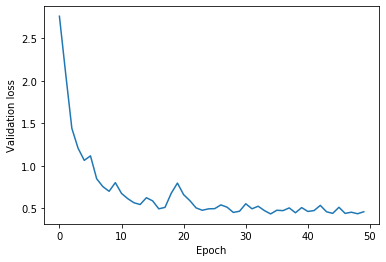

In [25]:
import matplotlib.pyplot as plt
plt.plot(model_train.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Validation loss')

Text(0, 0.5, 'Validation acc')

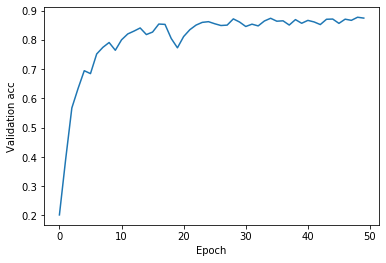

In [26]:
import matplotlib.pyplot as plt
plt.plot(model_train.history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Validation acc')

In [29]:
model1 = EdgespeechnetC()
model1.load_weights('./weights/EdgespeechC.hdf5')

In [30]:
model1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])


In [33]:
x = data_val
y = labels_val
model1.evaluate(x,y)

6798/6798 [==============================] - 3s 485us/sample - loss: 0.4378 - acc: 0.8772


[0.4378028409667894, 0.8771697]

In [37]:
import numpy as np
pred = model1.predict(x)

In [40]:
pred_label = np.argmax(pred,axis=1)

In [44]:
true_label = np.argmax(y,axis=1)

In [46]:
np.sum(pred_label == true_label)
print('Accuracy on Validation set:',np.sum(pred_label == true_label)/6798)

Accuracy on Validation set: 0.8771697558105325
